In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm

print('hello world')

hello world


In [25]:
# Load the S&P 500 data
df_sp500 = pd.read_csv('data/sp500_2015-2025.csv')

# Convert the 'Date' column to datetime format for better plotting
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])

# Sort the dataframe by date (ascending order)
df_sp500 = df_sp500.sort_values('Date')

# Conver string to float
df_sp500['Close/Last'] = df_sp500['Close/Last'].astype(float)
df_sp500['Open'] = df_sp500['Open'].astype(float)
df_sp500['High'] = df_sp500['High'].astype(float)
df_sp500['Low'] = df_sp500['Low'].astype(float)

# Display the first few rows of the data
df_sp500.head()

,Date,Close/Last,Open,High,Low
2520,2015-04-06,2080.62,2064.87,2086.99,2056.52
2519,2015-04-07,2076.33,2080.79,2089.81,2076.10
2518,2015-04-08,2081.90,2076.94,2086.69,2073.30
2517,2015-04-09,2091.18,2081.29,2093.31,2074.29
2516,2015-04-10,2102.06,2091.51,2102.61,2091.51


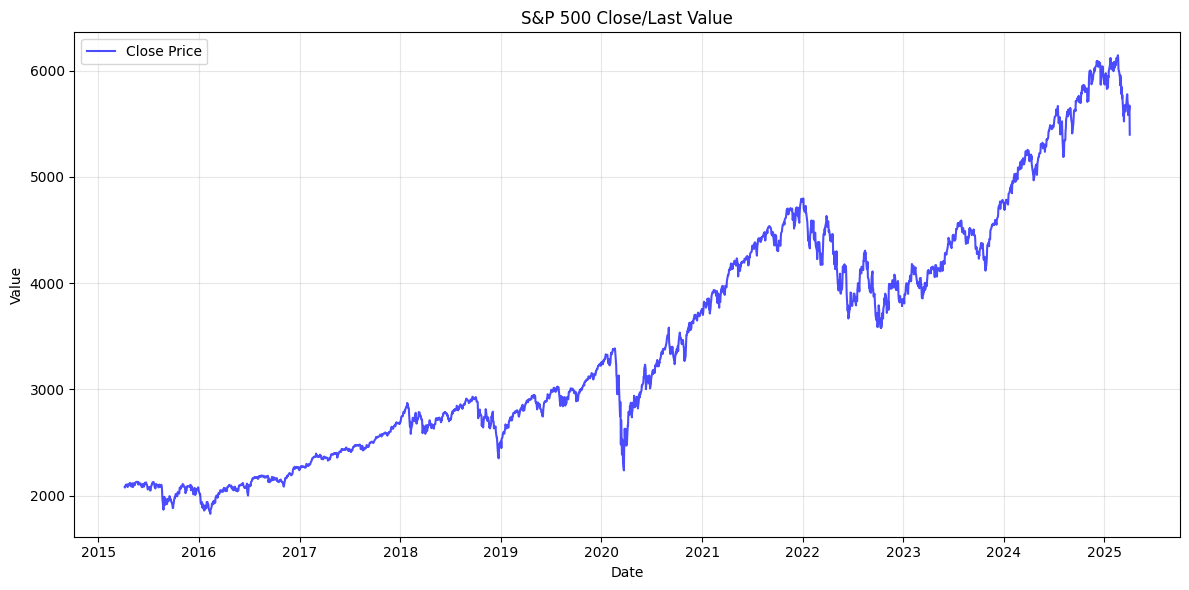

In [26]:
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot a single line that shows closing prices
plt.plot(df_sp500['Date'], df_sp500['Close/Last'], label='Close Price', color='blue', alpha=0.7)

# Customize the plot
plt.title('S&P 500 Close/Last Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

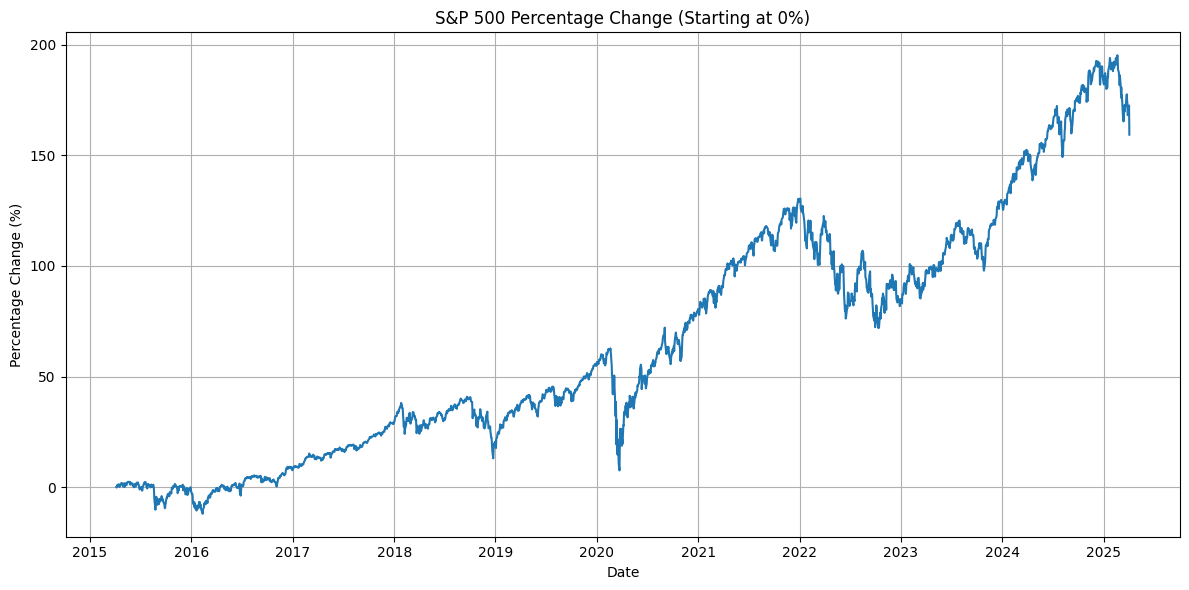

In [27]:
# Percentage change of close/last value

# Calculate the percentage change from the first day
first_price = df_sp500['Close/Last'].iloc[0]
df_sp500['Percent_Change'] = ((df_sp500['Close/Last'] - first_price) / first_price) * 100

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_sp500['Date'], df_sp500['Percent_Change'])
plt.title('S&P 500 Percentage Change (Starting at 0%)')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

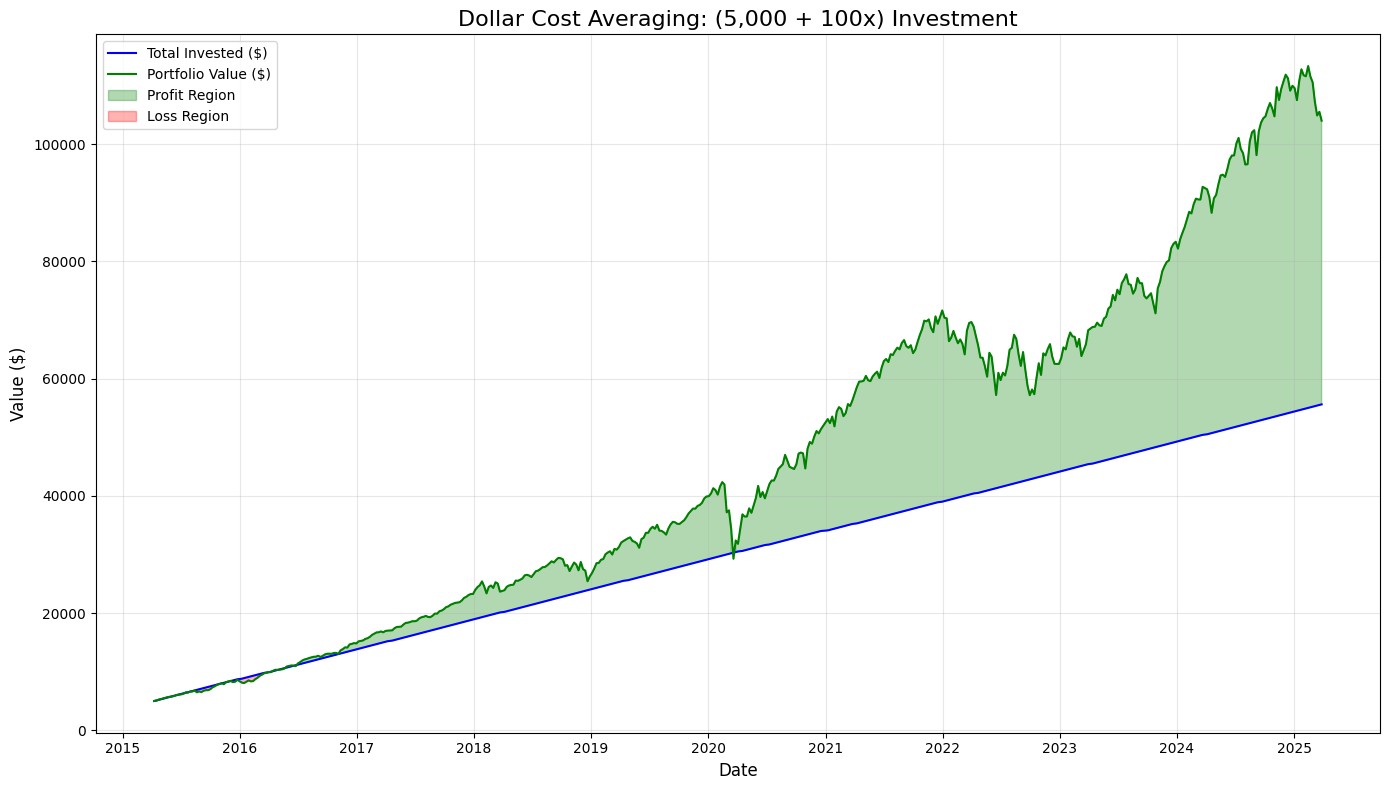

DCA Strategy Summary:
Start Date: 2015-04-10
End Date: 2025-03-28
Total Amount Invested: $55600.00
Final Portfolio Value: $104004.26
Total Profit/Loss: $48404.26 (87.06%)
Total Number of Shares Owned: 18.64
Average Cost Per Share: $2983.53
Final Share Price: $5580.94


In [28]:
# Simulate DCA strategy

# Filter for only Fridays (weekday 4 is Friday in Python)
fridays = df_sp500[df_sp500['Date'].dt.weekday == 4]

# Initialize variables for DCA strategy
initial_investment = 5000
weekly_investment = 100
total_invested = initial_investment
shares_owned = initial_investment / fridays.iloc[0]['Close/Last']
investment_value = []
investment_cost = []
dates = []

# Start with initial investment
dates.append(fridays.iloc[0]['Date'])
investment_value.append(shares_owned * fridays.iloc[0]['Close/Last'])
investment_cost.append(total_invested)

# Simulate buying $100 worth of shares every Friday
for i in range(1, len(fridays)):
    # Buy more shares with weekly investment
    new_shares = weekly_investment / fridays.iloc[i]['Close/Last']
    shares_owned += new_shares
    total_invested += weekly_investment
    
    # Record data
    dates.append(fridays.iloc[i]['Date'])
    investment_value.append(shares_owned * fridays.iloc[i]['Close/Last'])
    investment_cost.append(total_invested)

# Create a dataframe to hold our results
dca_results = pd.DataFrame({
    'Date': dates,
    'Total Invested': investment_cost,
    'Portfolio Value': investment_value,
    'Profit/Loss': np.array(investment_value) - np.array(investment_cost),
    'Return %': ((np.array(investment_value) - np.array(investment_cost)) / np.array(investment_cost)) * 100
})

# Plot the results
plt.figure(figsize=(14, 8))

# Plot total invested vs portfolio value
plt.plot(dca_results['Date'], dca_results['Total Invested'], label='Total Invested ($)', color='blue')
plt.plot(dca_results['Date'], dca_results['Portfolio Value'], label='Portfolio Value ($)', color='green')

# Highlight profit/loss region
plt.fill_between(dca_results['Date'], dca_results['Total Invested'], dca_results['Portfolio Value'], 
                 where=(dca_results['Portfolio Value'] >= dca_results['Total Invested']),
                 color='green', alpha=0.3, label='Profit Region')
plt.fill_between(dca_results['Date'], dca_results['Total Invested'], dca_results['Portfolio Value'], 
                 where=(dca_results['Portfolio Value'] <= dca_results['Total Invested']),
                 color='red', alpha=0.3, label='Loss Region')

# Customize the plot
plt.title('Dollar Cost Averaging: (5,000 + 100x) Investment', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Display summary statistics
print("DCA Strategy Summary:")
print(f"Start Date: {dca_results['Date'].min().strftime('%Y-%m-%d')}")
print(f"End Date: {dca_results['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total Amount Invested: ${dca_results['Total Invested'].iloc[-1]:.2f}")
print(f"Final Portfolio Value: ${dca_results['Portfolio Value'].iloc[-1]:.2f}")
profit_loss = dca_results['Portfolio Value'].iloc[-1] - dca_results['Total Invested'].iloc[-1]
print(f"Total Profit/Loss: ${profit_loss:.2f} ({profit_loss/dca_results['Total Invested'].iloc[-1]*100:.2f}%)")
print(f"Total Number of Shares Owned: {shares_owned:.2f}")
print(f"Average Cost Per Share: ${dca_results['Total Invested'].iloc[-1]/shares_owned:.2f}")
print(f"Final Share Price: ${fridays.iloc[-1]['Close/Last']:.2f}")

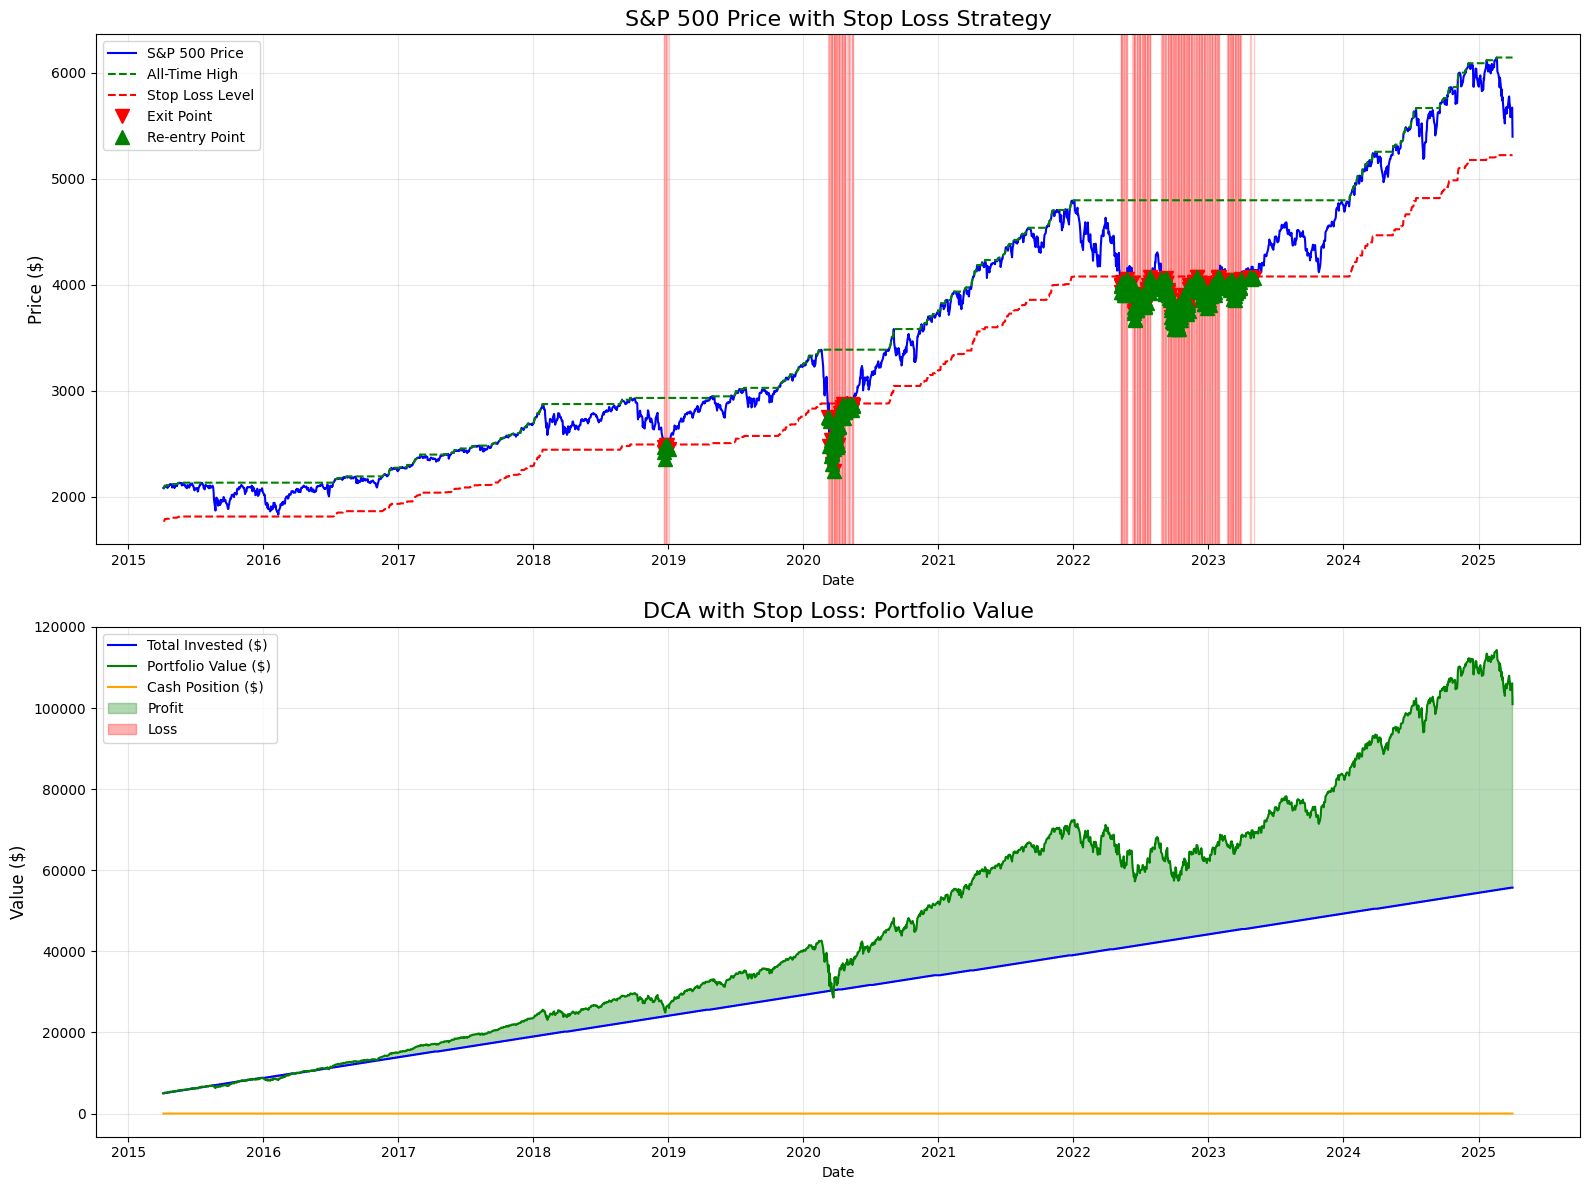

DCA with Stop Loss Strategy Summary:
Start Date: 2015-04-06
End Date: 2025-04-03
Total Amount Invested: $55700.00
Final Portfolio Value: $100956.47
Total Profit/Loss: $45256.47 (81.25%)
Final Shares Owned: 18.71
Final Cash Position: $0.00
Number of Stop Losses Triggered: 233
Number of Market Re-entries: 233


In [29]:
# Simulate DCA strategy with stop losses

# Initialize variables
initial_investment = 5000
weekly_investment = 100
stop_loss_percentage = 15  # 15% drop from all-time high

# Create a list to store daily values
dates = []
total_invested = []
portfolio_values = []
cash_position = []
shares_owned = []
all_time_highs = []
stop_loss_levels = []
is_invested = []
daily_investment = []

# Set up initial values
total_cash = 0  # Start with 0 cash since we'll invest initially
current_shares = 0
in_market = False
current_ath = 0
current_stop_loss = 0
last_exit_price = 0
market_exit_dates = []
market_reentry_dates = []
weekly_investment_counter = 0

# Process each day in the dataset
for i in range(len(df_sp500)):
    current_date = df_sp500.iloc[i]['Date']
    current_price = df_sp500.iloc[i]['Close/Last']
    
    # Initial buy on first day
    if i == 0:
        current_shares = initial_investment / current_price
        total_cash = 0
        in_market = True
        current_ath = current_price
        current_stop_loss = current_ath * (1 - stop_loss_percentage/100)
    
    # Update all-time high and stop loss level if we're in the market
    if in_market and current_price > current_ath:
        current_ath = current_price
        current_stop_loss = current_ath * (1 - stop_loss_percentage/100)
    
    # Check if it's Friday (weekly investment day)
    is_friday = current_date.weekday() == 4
    
    # Handle weekly investment (always happens, regardless of market status)
    daily_investment_amount = 0
    if is_friday:
        weekly_investment_counter += 1
        daily_investment_amount = weekly_investment
        
        if in_market:
            # Buy shares directly
            new_shares = weekly_investment / current_price
            current_shares += new_shares
        else:
            # Add to cash if not in market
            total_cash += weekly_investment
    
    # Check for stop loss trigger (only if we're in the market)
    if in_market and current_price <= current_stop_loss:
        # Sell all shares
        total_cash += current_shares * current_price
        last_exit_price = current_price
        current_shares = 0
        in_market = False
        market_exit_dates.append(current_date)
    
    # Check for re-entry condition (only if we're out of market and have cash)
    if not in_market and current_price >= last_exit_price and last_exit_price > 0 and total_cash > 0:
        # Re-enter the market with all cash
        current_shares = total_cash / current_price
        total_cash = 0
        in_market = True
        market_reentry_dates.append(current_date)
    
    # Calculate current portfolio value
    portfolio_value = current_shares * current_price + total_cash
    
    # Record data for this day
    dates.append(current_date)
    total_investment_to_date = initial_investment + weekly_investment_counter * weekly_investment
    total_invested.append(total_investment_to_date)
    portfolio_values.append(portfolio_value)
    cash_position.append(total_cash)
    shares_owned.append(current_shares)
    all_time_highs.append(current_ath)
    stop_loss_levels.append(current_stop_loss)
    is_invested.append(in_market)
    daily_investment.append(daily_investment_amount)

# Create a dataframe with our results
stop_loss_results = pd.DataFrame({
    'Date': dates,
    'Price': df_sp500['Close/Last'].values,
    'All-Time High': all_time_highs,
    'Stop Loss Level': stop_loss_levels,
    'Is Invested': is_invested,
    'Shares Owned': shares_owned,
    'Cash Position': cash_position,
    'Portfolio Value': portfolio_values,
    'Daily Investment': daily_investment,
    'Total Invested': total_invested
})

# Calculate return metrics
stop_loss_results['Return %'] = ((stop_loss_results['Portfolio Value'] - stop_loss_results['Total Invested']) / 
                                stop_loss_results['Total Invested']) * 100

# Plot the results
plt.figure(figsize=(16, 12))

# Create a subplot for the price and stop loss
plt.subplot(2, 1, 1)
plt.plot(stop_loss_results['Date'], stop_loss_results['Price'], label='S&P 500 Price', color='blue')
plt.plot(stop_loss_results['Date'], stop_loss_results['All-Time High'], label='All-Time High', color='green', linestyle='--')
plt.plot(stop_loss_results['Date'], stop_loss_results['Stop Loss Level'], label='Stop Loss Level', color='red', linestyle='--')

# Highlight periods when not invested
for i in range(len(market_exit_dates)):
    if i < len(market_reentry_dates):
        plt.axvspan(market_exit_dates[i], market_reentry_dates[i], color='red', alpha=0.2)
    else:
        # If we exited but never re-entered, shade to the end
        plt.axvspan(market_exit_dates[i], stop_loss_results['Date'].iloc[-1], color='red', alpha=0.2)

# Mark exit and entry points
for date in market_exit_dates:
    idx = stop_loss_results[stop_loss_results['Date'] == date].index[0]
    plt.plot(date, stop_loss_results.loc[idx, 'Price'], 'rv', markersize=10, label='Exit Point' if date == market_exit_dates[0] else '')

for date in market_reentry_dates:
    idx = stop_loss_results[stop_loss_results['Date'] == date].index[0]
    plt.plot(date, stop_loss_results.loc[idx, 'Price'], 'g^', markersize=10, label='Re-entry Point' if date == market_reentry_dates[0] else '')

plt.title('S&P 500 Price with Stop Loss Strategy', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Create a subplot for portfolio value and cash
plt.subplot(2, 1, 2)
plt.plot(stop_loss_results['Date'], stop_loss_results['Total Invested'], label='Total Invested ($)', color='blue')
plt.plot(stop_loss_results['Date'], stop_loss_results['Portfolio Value'], label='Portfolio Value ($)', color='green')
plt.plot(stop_loss_results['Date'], stop_loss_results['Cash Position'], label='Cash Position ($)', color='orange')

# Highlight profit/loss region
plt.fill_between(stop_loss_results['Date'], stop_loss_results['Total Invested'], stop_loss_results['Portfolio Value'],
                where=(stop_loss_results['Portfolio Value'] >= stop_loss_results['Total Invested']),
                color='green', alpha=0.3, label='Profit')
plt.fill_between(stop_loss_results['Date'], stop_loss_results['Total Invested'], stop_loss_results['Portfolio Value'],
                where=(stop_loss_results['Portfolio Value'] <= stop_loss_results['Total Invested']),
                color='red', alpha=0.3, label='Loss')

plt.title('DCA with Stop Loss: Portfolio Value', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Value ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Display summary statistics
print("DCA with Stop Loss Strategy Summary:")
print(f"Start Date: {stop_loss_results['Date'].min().strftime('%Y-%m-%d')}")
print(f"End Date: {stop_loss_results['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total Amount Invested: ${stop_loss_results['Total Invested'].iloc[-1]:.2f}")
print(f"Final Portfolio Value: ${stop_loss_results['Portfolio Value'].iloc[-1]:.2f}")
profit_loss = stop_loss_results['Portfolio Value'].iloc[-1] - stop_loss_results['Total Invested'].iloc[-1]
print(f"Total Profit/Loss: ${profit_loss:.2f} ({profit_loss/stop_loss_results['Total Invested'].iloc[-1]*100:.2f}%)")
print(f"Final Shares Owned: {stop_loss_results['Shares Owned'].iloc[-1]:.2f}")
print(f"Final Cash Position: ${stop_loss_results['Cash Position'].iloc[-1]:.2f}")
print(f"Number of Stop Losses Triggered: {len(market_exit_dates)}")
print(f"Number of Market Re-entries: {len(market_reentry_dates)}")

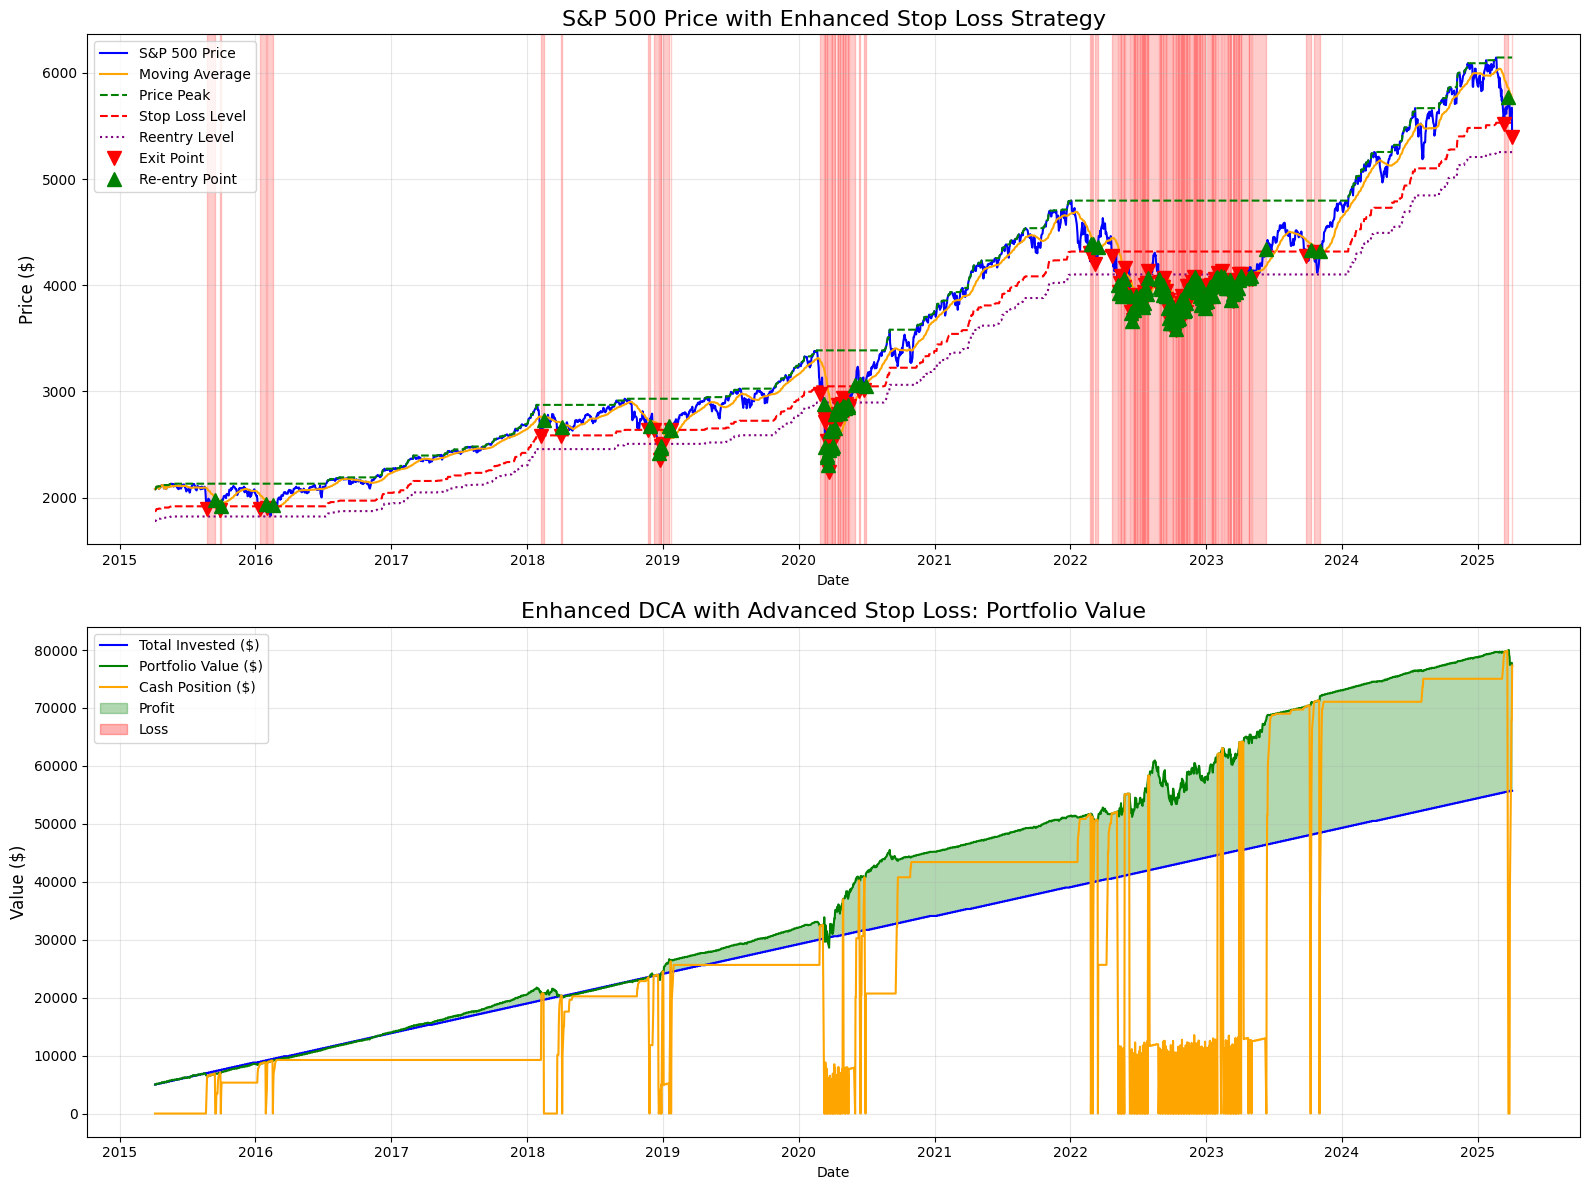

Enhanced DCA with Advanced Stop Loss Strategy Summary:
Start Date: 2015-04-06
End Date: 2025-04-03
Total Amount Invested: $55700.00
Final Portfolio Value: $77317.89
Total Profit/Loss: $21617.89 (38.81%)
Final Shares Owned: 0.00
Final Cash Position: $77317.89
Number of Stop Losses Triggered: 142
Number of Market Re-entries: 141

Improvement over previous strategy: -23.41%


In [30]:
# Simulate Enhanced DCA strategy with advanced stop losses and trend detection

# Initialize variables
initial_investment = 5000
weekly_investment = 100
stop_loss_percentage = 10  # 10% drop from peak
lookback_period = 30 * 6  # ~6 months (trading days)
reentry_drop_percentage = 5  # 5% below the stop loss
partial_exit_threshold = 8  # First partial exit at 8% drop
partial_exit_percentage = 50  # Sell 50% at first threshold
trend_detection_window = 30  # 30-day moving average for trend detection
max_cash_allocation = 80  # Max percentage of portfolio to keep in cash
increase_dca_in_downtrends = True  # Increase DCA amount in downtrends

# Create a list to store daily values
dates = []
total_invested = []
portfolio_values = []
cash_position = []
shares_owned = []
price_peaks = []
stop_loss_levels = []
reentry_levels = []
moving_averages = []
is_invested = []
daily_investment = []
trend_signals = []

# Set up initial values
total_cash = 0
current_shares = 0
in_market = False
current_peak = 0
current_stop_loss = 0
current_reentry_level = 0
last_exit_price = 0
market_exit_dates = []
market_reentry_dates = []
weekly_investment_counter = 0
trend_direction = 0  # 0=neutral, 1=uptrend, -1=downtrend

# Process each day in the dataset
for i in range(len(df_sp500)):
    current_date = df_sp500.iloc[i]['Date']
    current_price = df_sp500.iloc[i]['Close/Last']
    
    # Calculate moving average for trend detection
    if i >= trend_detection_window:
        ma_window = df_sp500.iloc[i-trend_detection_window:i+1]['Close/Last']
        current_ma = ma_window.mean()
        # Detect trend by comparing current price to MA
        if current_price > current_ma * 1.02:  # 2% above MA = uptrend
            trend_direction = 1
        elif current_price < current_ma * 0.98:  # 2% below MA = downtrend
            trend_direction = -1
        else:
            trend_direction = 0  # Neutral
    else:
        current_ma = current_price
        trend_direction = 0
    
    # Determine price peak (instead of fixed lookback, use trailing peak)
    if current_price > current_peak:
        current_peak = current_price
        # Update stop loss and reentry levels with the new peak
        current_stop_loss = current_peak * (1 - stop_loss_percentage/100)
        current_reentry_level = current_stop_loss * (1 - reentry_drop_percentage/100)
    
    # Initial buy on first day
    if i == 0:
        current_shares = initial_investment / current_price
        total_cash = 0
        in_market = True
        current_peak = current_price
        current_stop_loss = current_peak * (1 - stop_loss_percentage/100)
        current_reentry_level = current_stop_loss * (1 - reentry_drop_percentage/100)
    
    # Check if it's Friday (weekly investment day)
    is_friday = current_date.weekday() == 4
    
    # Determine weekly investment amount (adjust based on trend)
    daily_investment_amount = 0
    if is_friday:
        weekly_investment_counter += 1
        
        # Adjust weekly investment in downtrends if enabled
        if trend_direction == -1 and increase_dca_in_downtrends:
            adjusted_weekly_investment = weekly_investment * 1.5  # 50% more in downtrends
        else:
            adjusted_weekly_investment = weekly_investment
            
        daily_investment_amount = adjusted_weekly_investment
        
        if in_market:
            # Buy shares directly
            new_shares = adjusted_weekly_investment / current_price
            current_shares += new_shares
        else:
            # Add to cash if not in market
            total_cash += adjusted_weekly_investment
    
    # Check for partial exit trigger (only if fully invested)
    if in_market and current_price <= (current_peak * (1 - partial_exit_threshold/100)) and current_price > current_stop_loss:
        # Sell a portion of shares
        shares_to_sell = current_shares * (partial_exit_percentage/100)
        total_cash += shares_to_sell * current_price
        current_shares -= shares_to_sell
        
        # Don't mark as full exit, just partial
        if total_cash > 0 and current_shares > 0:
            in_market = True  # Still have some position
            # We could add a list of partial exit dates if we wanted to track
    
    # Check for stop loss trigger (only if we're in the market)
    if in_market and current_price <= current_stop_loss:
        # Sell all remaining shares
        total_cash += current_shares * current_price
        last_exit_price = current_price
        current_shares = 0
        in_market = False
        market_exit_dates.append(current_date)
    
    # Check for re-entry conditions (only if we're out of market or partially out)
    if not in_market and total_cash > 0:
        # Condition 1: Price drops to our reentry level
        if current_price <= current_reentry_level:
            # Calculate how much to invest based on max cash allocation rule
            cash_to_invest = min(total_cash, (portfolio_value * max_cash_allocation/100)) if i > 0 else total_cash
            
            # Re-enter the market with calculated cash amount
            new_shares = cash_to_invest / current_price
            current_shares += new_shares
            total_cash -= cash_to_invest
            
            if total_cash <= 0.01:  # Small threshold for rounding errors
                in_market = True
                market_reentry_dates.append(current_date)
        
        # Condition 2: Price rises back to stop-loss level and trend is positive
        elif current_price >= current_stop_loss and trend_direction >= 0:
            # Re-enter the market with all cash when we have confirmation
            current_shares += total_cash / current_price
            total_cash = 0
            in_market = True
            market_reentry_dates.append(current_date)
    
    # Calculate current portfolio value
    portfolio_value = current_shares * current_price + total_cash
    
    # Record data for this day
    dates.append(current_date)
    total_investment_to_date = initial_investment + weekly_investment_counter * weekly_investment
    total_invested.append(total_investment_to_date)
    portfolio_values.append(portfolio_value)
    cash_position.append(total_cash)
    shares_owned.append(current_shares)
    price_peaks.append(current_peak)
    stop_loss_levels.append(current_stop_loss)
    reentry_levels.append(current_reentry_level)
    moving_averages.append(current_ma)
    is_invested.append(in_market)
    daily_investment.append(daily_investment_amount)
    trend_signals.append(trend_direction)

# Create a dataframe with our results
enhanced_results = pd.DataFrame({
    'Date': dates,
    'Price': df_sp500['Close/Last'].values,
    'Moving Average': moving_averages,
    'Price Peak': price_peaks,
    'Stop Loss Level': stop_loss_levels,
    'Reentry Level': reentry_levels,
    'Trend Signal': trend_signals,
    'Is Invested': is_invested,
    'Shares Owned': shares_owned,
    'Cash Position': cash_position,
    'Portfolio Value': portfolio_values,
    'Daily Investment': daily_investment,
    'Total Invested': total_invested
})

# Calculate return metrics
enhanced_results['Return %'] = ((enhanced_results['Portfolio Value'] - enhanced_results['Total Invested']) / 
                              enhanced_results['Total Invested']) * 100

# Plot the results
plt.figure(figsize=(16, 12))

# Create a subplot for the price and stop loss
plt.subplot(2, 1, 1)
plt.plot(enhanced_results['Date'], enhanced_results['Price'], label='S&P 500 Price', color='blue')
plt.plot(enhanced_results['Date'], enhanced_results['Moving Average'], label='Moving Average', color='orange', linestyle='-')
plt.plot(enhanced_results['Date'], enhanced_results['Price Peak'], label='Price Peak', color='green', linestyle='--')
plt.plot(enhanced_results['Date'], enhanced_results['Stop Loss Level'], label='Stop Loss Level', color='red', linestyle='--')
plt.plot(enhanced_results['Date'], enhanced_results['Reentry Level'], label='Reentry Level', color='purple', linestyle=':')

# Highlight periods when not invested
for i in range(len(market_exit_dates)):
    if i < len(market_reentry_dates):
        plt.axvspan(market_exit_dates[i], market_reentry_dates[i], color='red', alpha=0.2)
    else:
        # If we exited but never re-entered, shade to the end
        plt.axvspan(market_exit_dates[i], enhanced_results['Date'].iloc[-1], color='red', alpha=0.2)

# Mark exit and entry points
for date in market_exit_dates:
    idx = enhanced_results[enhanced_results['Date'] == date].index[0]
    plt.plot(date, enhanced_results.loc[idx, 'Price'], 'rv', markersize=10, label='Exit Point' if date == market_exit_dates[0] else '')

for date in market_reentry_dates:
    idx = enhanced_results[enhanced_results['Date'] == date].index[0]
    plt.plot(date, enhanced_results.loc[idx, 'Price'], 'g^', markersize=10, label='Re-entry Point' if date == market_reentry_dates[0] else '')

plt.title('S&P 500 Price with Enhanced Stop Loss Strategy', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Create a subplot for portfolio value and cash
plt.subplot(2, 1, 2)
plt.plot(enhanced_results['Date'], enhanced_results['Total Invested'], label='Total Invested ($)', color='blue')
plt.plot(enhanced_results['Date'], enhanced_results['Portfolio Value'], label='Portfolio Value ($)', color='green')
plt.plot(enhanced_results['Date'], enhanced_results['Cash Position'], label='Cash Position ($)', color='orange')

# Highlight profit/loss region
plt.fill_between(enhanced_results['Date'], enhanced_results['Total Invested'], enhanced_results['Portfolio Value'],
               where=(enhanced_results['Portfolio Value'] >= enhanced_results['Total Invested']),
               color='green', alpha=0.3, label='Profit')
plt.fill_between(enhanced_results['Date'], enhanced_results['Total Invested'], enhanced_results['Portfolio Value'],
               where=(enhanced_results['Portfolio Value'] <= enhanced_results['Total Invested']),
               color='red', alpha=0.3, label='Loss')

plt.title('Enhanced DCA with Advanced Stop Loss: Portfolio Value', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Value ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Display summary statistics
print("Enhanced DCA with Advanced Stop Loss Strategy Summary:")
print(f"Start Date: {enhanced_results['Date'].min().strftime('%Y-%m-%d')}")
print(f"End Date: {enhanced_results['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total Amount Invested: ${enhanced_results['Total Invested'].iloc[-1]:.2f}")
print(f"Final Portfolio Value: ${enhanced_results['Portfolio Value'].iloc[-1]:.2f}")
profit_loss = enhanced_results['Portfolio Value'].iloc[-1] - enhanced_results['Total Invested'].iloc[-1]
print(f"Total Profit/Loss: ${profit_loss:.2f} ({profit_loss/enhanced_results['Total Invested'].iloc[-1]*100:.2f}%)")
print(f"Final Shares Owned: {enhanced_results['Shares Owned'].iloc[-1]:.2f}")
print(f"Final Cash Position: ${enhanced_results['Cash Position'].iloc[-1]:.2f}")
print(f"Number of Stop Losses Triggered: {len(market_exit_dates)}")
print(f"Number of Market Re-entries: {len(market_reentry_dates)}")

# Compare with original strategy
original_final_value = stop_loss_results['Portfolio Value'].iloc[-1]
enhanced_final_value = enhanced_results['Portfolio Value'].iloc[-1]
improvement = ((enhanced_final_value - original_final_value) / original_final_value) * 100
print(f"\nImprovement over previous strategy: {improvement:.2f}%")